In [1]:
import xgboost as xgb
import optuna
import shap
import joblib
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score

TRAINING MODEL

Defining x an y for train and test

In [2]:
os.chdir('c:\\Renzo\\Projects\\credit-risk-ai\\')
train = pd.read_parquet('data/train_encoded.parquet')
test = pd.read_parquet('data/test_encoded.parquet')

In [3]:
X_train = train.drop(columns=['target'])
y_train = train['target']
X_test = test.drop(columns=['target'])
y_test =  test['target']

In [4]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test, label=y_test)

Defining Optuna Objective function

In [5]:
def train(params,trial):

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-auc")

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtest, 'test')],
        early_stopping_rounds=50,
        verbose_eval=False,
        callbacks=[pruning_callback]
    )

    y_pred = model.predict(dtest)
    auc = roc_auc_score(y_test, y_pred)

    return auc


In [6]:
def objective(trial):
    
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'random_state': 42,
        'tree_method': 'hist',
        'n_jobs': -1
    }

    return train(params, trial)

In [7]:
func = lambda trial: objective(trial)
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(func, n_trials=30, timeout=1800)

[I 2025-11-16 22:56:28,869] A new study created in memory with name: no-name-2d2181b3-5476-4b2a-a290-e2eb84a2cb03
[I 2025-11-16 22:56:31,362] Trial 0 finished with value: 0.7380037858627906 and parameters: {'eta': 0.10533209000879556, 'max_depth': 6, 'min_child_weight': 2.366906915414531, 'subsample': 0.6068076026866825, 'colsample_bytree': 0.633773117219098, 'lambda': 0.22281998234774378, 'alpha': 0.028356929126365133}. Best is trial 0 with value: 0.7380037858627906.
[I 2025-11-16 22:56:32,232] Trial 1 finished with value: 0.7096301056776003 and parameters: {'eta': 0.29330197600459057, 'max_depth': 10, 'min_child_weight': 7.987765261594376, 'subsample': 0.7707649504485525, 'colsample_bytree': 0.7371348876673361, 'lambda': 0.39266099388052617, 'alpha': 0.019157568385520112}. Best is trial 0 with value: 0.7380037858627906.
[I 2025-11-16 22:56:36,643] Trial 2 finished with value: 0.7410356361843874 and parameters: {'eta': 0.1087498276848728, 'max_depth': 3, 'min_child_weight': 6.41015113

In [8]:
print(f"\nBest AUC: {study.best_value:.4f}")
print(f"Best params: {study.best_params}")


Best AUC: 0.7410
Best params: {'eta': 0.1087498276848728, 'max_depth': 3, 'min_child_weight': 6.410151133457509, 'subsample': 0.6423616272839581, 'colsample_bytree': 0.6144092084026654, 'lambda': 0.004956386883287677, 'alpha': 7.089839421594705}


In [9]:
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': 77,
    'tree_method': 'hist',
    'n_jobs': -1
})

final_model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtest, 'test')],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	test-auc:0.67388
[100]	test-auc:0.72922
[200]	test-auc:0.73641
[300]	test-auc:0.73869
[400]	test-auc:0.73977
[500]	test-auc:0.74063
[600]	test-auc:0.74093
[700]	test-auc:0.74123
[761]	test-auc:0.74112


In [10]:
test_pred = final_model.predict(dtest)
final_auc = roc_auc_score(y_test, test_pred)
print(f'Final test auc: {final_auc:.4f}')

Final test auc: 0.7411


In [11]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X_test)

In [28]:
os.makedirs('models', exist_ok=True)
joblib.dump(final_model, 'models/xgb_model.pkl')
joblib.dump(explainer, 'models/shap_explainer.pkl')

['models/shap_explainer.pkl']

In [29]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig('shap_summary.png', bbox_inches='tight', dpi=150)
plt.close()

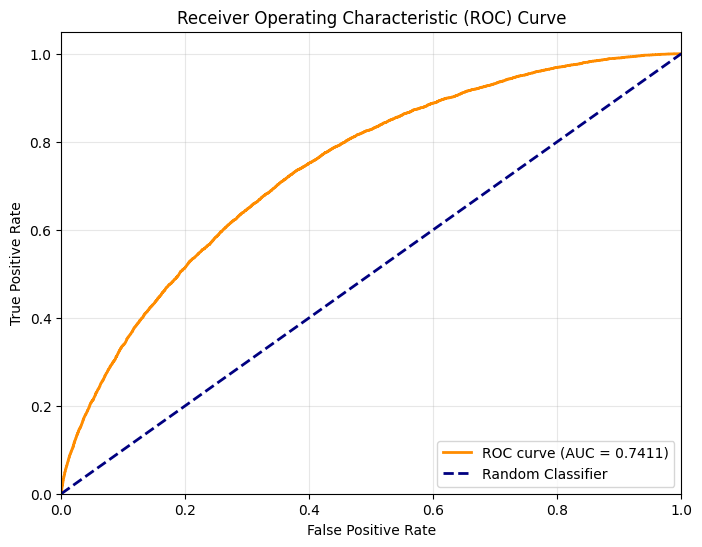

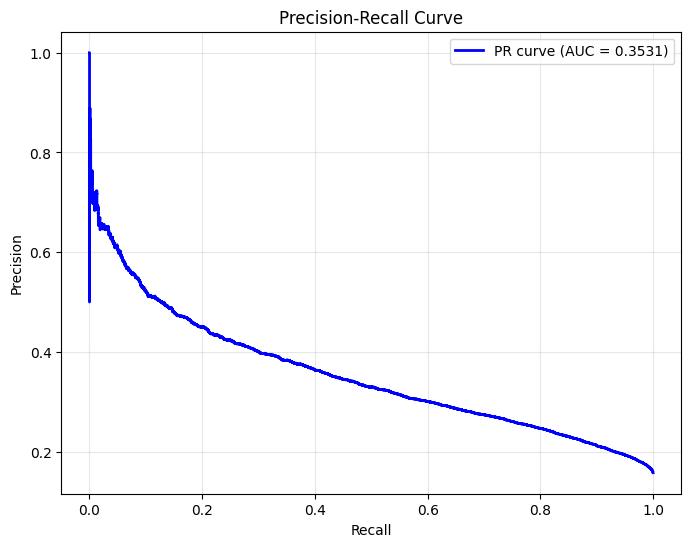

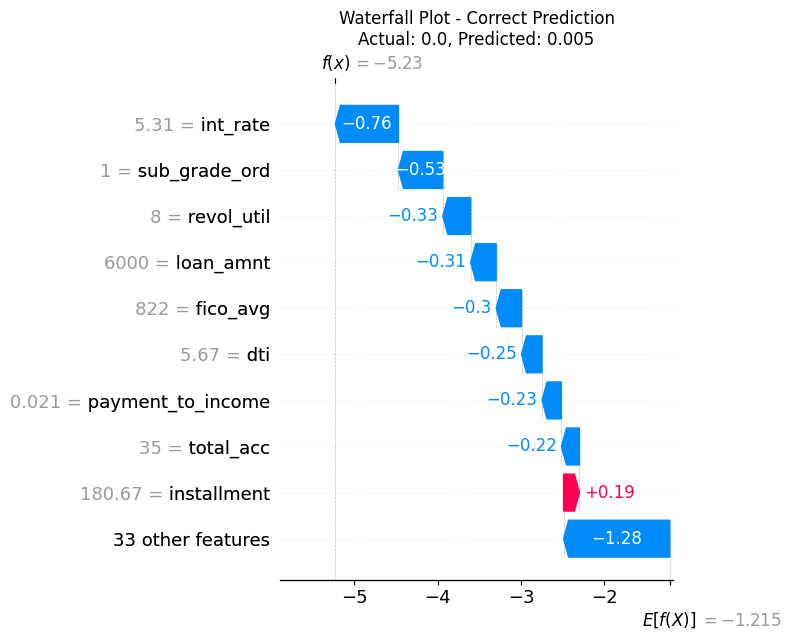

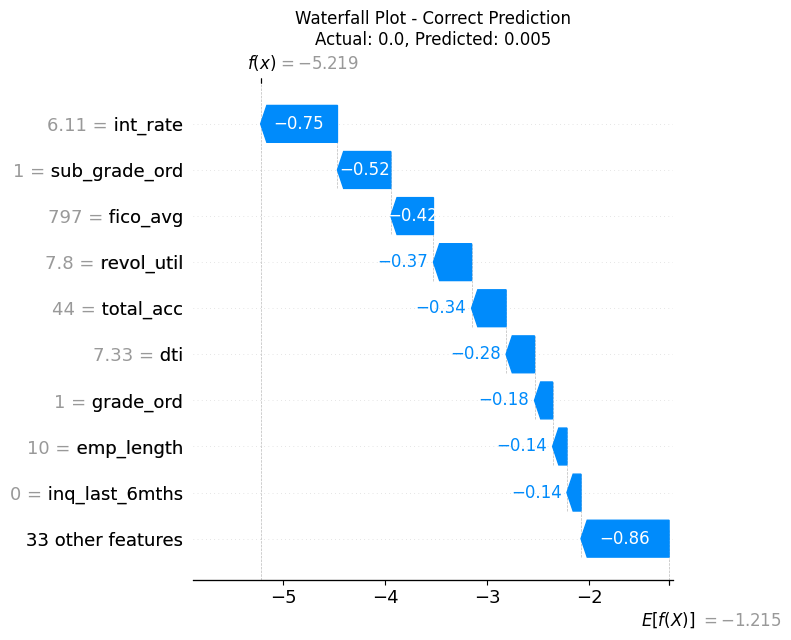

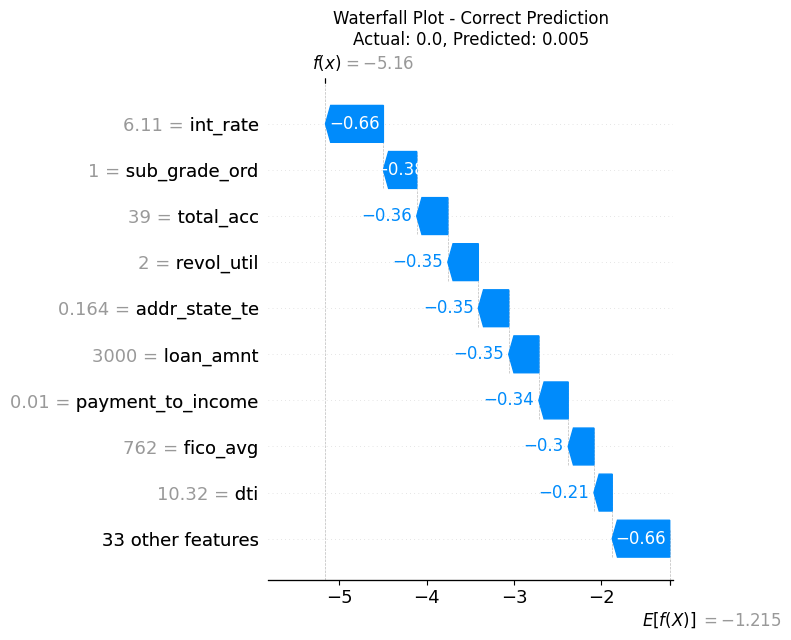

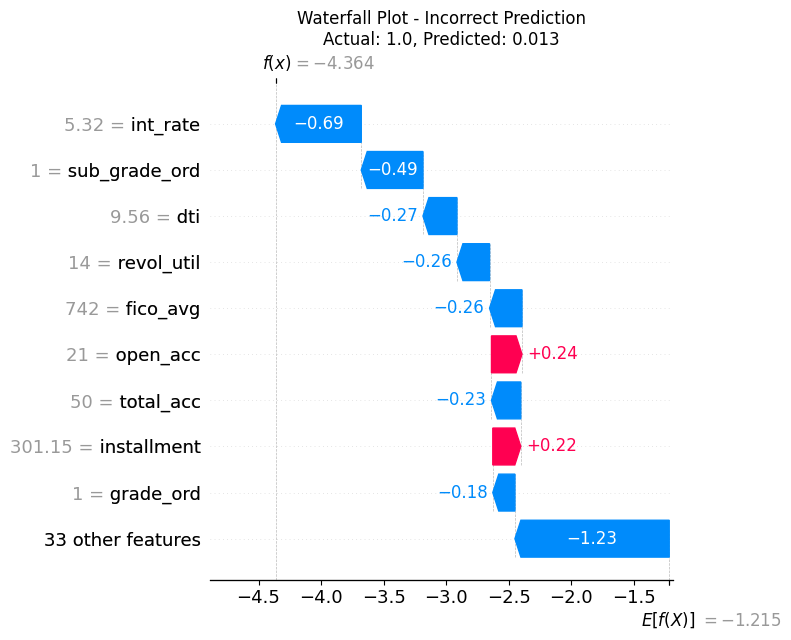

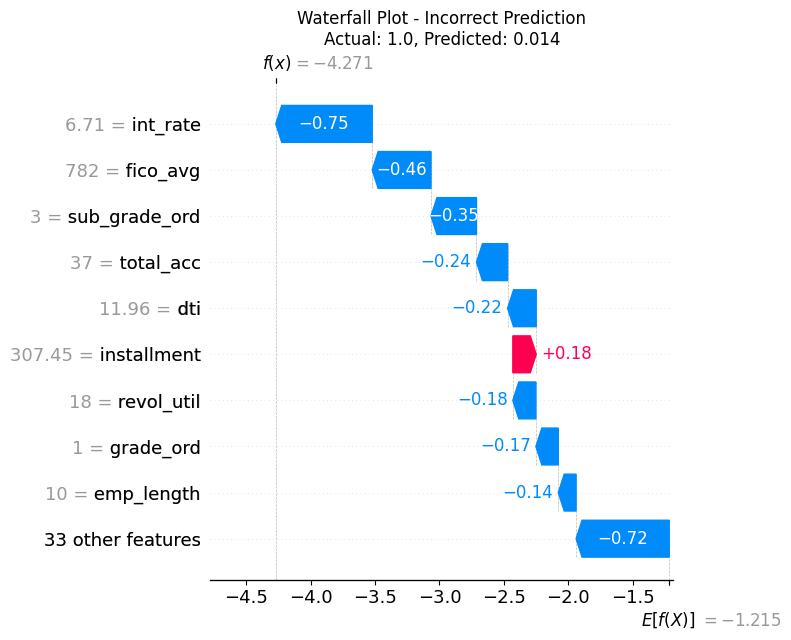

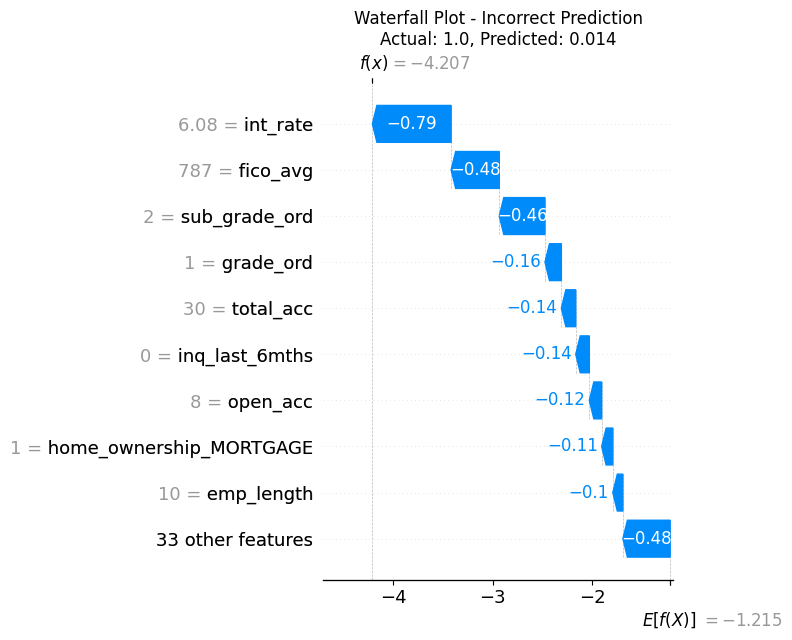

<Figure size 1200x600 with 0 Axes>

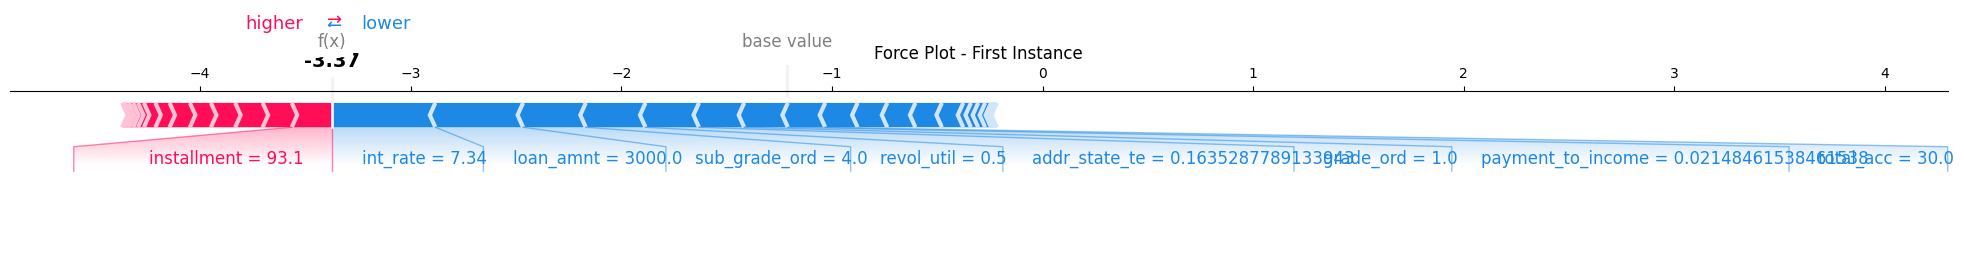

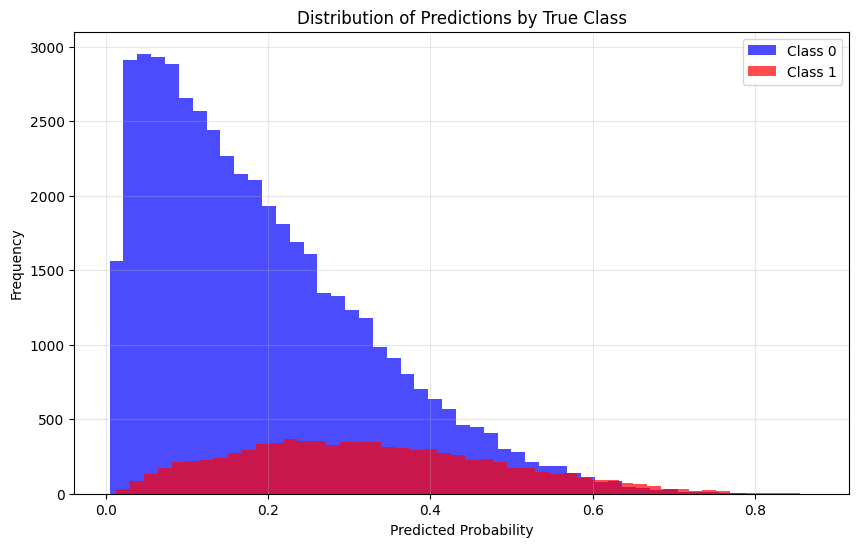

Final test AUC: 0.7411
ROC AUC: 0.7411
PR AUC: 0.3531


In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import shap

# 1. AUC-ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, test_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('auc_roc_curve.png', bbox_inches='tight', dpi=150)
plt.show()

# 2. Precision-Recall Curve
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test, test_pred)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.savefig('precision_recall_curve.png', bbox_inches='tight', dpi=150)
plt.show()

# 3. Waterfall plots for specific instances - UPDATED
def plot_waterfall_instances(explainer, X_test, y_test, test_pred, n_instances=3):
    """Plot waterfall plots for top correct and incorrect predictions"""
    
    # Get indices of highest probability predictions for each class
    correct_mask = (test_pred > 0.5) == y_test
    incorrect_mask = (test_pred > 0.5) != y_test
    
    correct_indices = np.where(correct_mask)[0]
    incorrect_indices = np.where(incorrect_mask)[0]
    
    # Sort by prediction confidence
    if len(correct_indices) > 0:
        correct_sorted = sorted(correct_indices, key=lambda x: abs(test_pred[x] - 0.5), reverse=True)
    else:
        correct_sorted = []
        
    if len(incorrect_indices) > 0:
        incorrect_sorted = sorted(incorrect_indices, key=lambda x: abs(test_pred[x] - 0.5), reverse=True)
    else:
        incorrect_sorted = []
    
    # Plot correct predictions - UPDATED
    for i in range(min(n_instances, len(correct_sorted))):
        idx = correct_sorted[i]
        plt.figure(figsize=(10, 6))
        
        # Updated waterfall plot call
        shap.plots.waterfall(shap_values[idx], show=False)
        plt.title(f'Waterfall Plot - Correct Prediction\n'
                 f'Actual: {y_test.iloc[idx]}, Predicted: {test_pred[idx]:.3f}')
        plt.tight_layout()
        plt.savefig(f'waterfall_correct_{i+1}.png', bbox_inches='tight', dpi=150)
        plt.show()
    
    # Plot incorrect predictions - UPDATED
    for i in range(min(n_instances, len(incorrect_sorted))):
        idx = incorrect_sorted[i]
        plt.figure(figsize=(10, 6))
        
        # Updated waterfall plot call
        shap.plots.waterfall(shap_values[idx], show=False)
        plt.title(f'Waterfall Plot - Incorrect Prediction\n'
                 f'Actual: {y_test.iloc[idx]}, Predicted: {test_pred[idx]:.3f}')
        plt.tight_layout()
        plt.savefig(f'waterfall_incorrect_{i+1}.png', bbox_inches='tight', dpi=150)
        plt.show()

# Generate waterfall plots
plot_waterfall_instances(explainer, X_test, y_test, test_pred, n_instances=3)

# 4. Force plot for first instance - UPDATED
plt.figure(figsize=(12, 6))
shap.plots.force(explainer.expected_value, shap_values[0].values, X_test.iloc[0], 
                matplotlib=True, show=False)
plt.title('Force Plot - First Instance')
plt.tight_layout()
plt.savefig('force_plot_first_instance.png', bbox_inches='tight', dpi=150)
plt.show()

# 5. Distribution of predictions
plt.figure(figsize=(10, 6))
plt.hist(test_pred[y_test == 0], bins=50, alpha=0.7, label='Class 0', color='blue')
plt.hist(test_pred[y_test == 1], bins=50, alpha=0.7, label='Class 1', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions by True Class')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('prediction_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

print(f"Final test AUC: {final_auc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")